C:\Users\rashedi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:184: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Text(0.5, 1.0, 'Internal energy at 6')

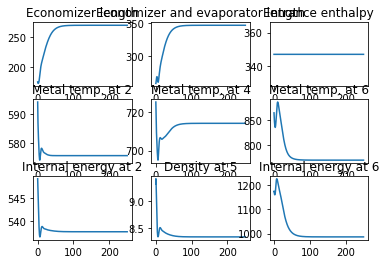

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

Ts = 0.001
Tf = 2.5e5

# Inputs
# G=2.19
G = 0.97
Tg7 = 1247.3
P7 = 2600
# W1=2.545
W1 = 1.22
hfw = 347
# hfw=350

# Some general constants
Cp=1.242
Cv=0.746
L=349
g=32.2
A=2.9065e-3
Ao=0.26179
Ai=0.1911
Ag=0.18438
Cm=0.156
Kpt1=261.046
Kx=(Cv-Cp)*Ag*Kpt1
Yg=Kx/G/Cp
Co=0.818
Ci=0.597
D_ro_u=-0.05

# Economizer constants
Kf2=2.5
Kgm2=16.4337
Kmf2=1.14
Kh2=0.49343
Kt2=0.376916
Kr2=0.7375
Kp2=0.4
L13_0=176
h1_0=347 
u2_0=549.26
Tm2_0=594.24

# Evaporator constants
Kf4=5.263
Kgm4=16.6448
Kmf4=0.75385
Kh4=0.5
Kr4=0.5241
L15_0=257.72
dens5_0=9.3089
Tm4_0=725.31

# Superheater constants
Kgm6=18.1376
Kmf6=2.854
Kr6=0.46
Kp6=0.5
Kf6=3.1453
Kh6=0.4177
u6_0=1172.7
Tm6_0=864.77

# State vector preparation
L13=np.zeros(int(Tf)); L13[0]=L13_0;
L15=np.zeros(int(Tf)); L15[0]=L15_0;
u2=np.zeros(int(Tf)); u2[0]=u2_0; 
u6=np.zeros(int(Tf)); u6[0]=u6_0;
dens5=np.zeros(int(Tf)); dens5[0]=dens5_0;
Tm2=np.zeros(int(Tf)); Tm2[0]=Tm2_0;
Tm4=np.zeros(int(Tf)); Tm4[0]=Tm4_0;
Tm6=np.zeros(int(Tf)); Tm6[0]=Tm6_0;
h1=np.zeros(int(Tf)); h1[0]=h1_0;

count=[]

# Differential and auxiliary equations
for k in range(0,int(Tf)-1):
    
    # Economizer auxiliary equations
    T1=h1[k]+23
    dens1=67.1-0.033*h1[k]
    h2=u2[k]+11.7
    h3=(h2-Kh2*h1[k])/(1-Kh2)
    dens3=-181.43+0.9212*h3-0.12053e-2*(h3**2)+0.4784e-6*h3**3
    dens2=1/(Kr2/dens1+(1-Kr2)/dens3)
    T3=526.55+14.491*dens3-0.2986*dens3**2
    T2=Kt2*T1+T3*(1-Kt2)
    P3=15014-54.365*T3+0.05334*T3**2
    P1=P3+Kf2*W1*abs(W1)*L13[k]/dens2
    
    # Evaporator auxiliary equations
    h5=1252.5-22.8*dens5[k]+0.26*dens5[k]**2
    T5=12364-34.711*h5+.03467*h5**2-0.11624e-4*h5**3
    P5=116060-341.62*h5+0.34883*h5**2-0.12017e-3*h5**3
    dens4=1/(Kr4/dens3+(1-Kr4)/dens5[k])
    h4=h3*Kh4+(1-Kh4)*h5
    T4=125.82-1658.61/dens4+8087.2/(dens4**2)-0.95309*h4/dens4+1.089*h4-.3621e-3*h4**2
    u4=h4-35
    P35=P3-P5
    L35=L15[k]-L13[k]
    W3=math.sqrt(abs(P35)*dens4/L35/Kf4)
    
    # Superheater auxiliary equations
    P57=P5-P7
    h6=u6[k]+99.6
    h7=(h6-Kh6*h5)/(1-Kh6)
    P6=Kp6*P5+(1-Kp6)*P7
    T6=2111.9245+0.23115*P6-0.101325e-4*P6**2-0.837951e-4*P6*h6-3.62587*h6+0.0018637*h6**2
    T7=2111.9245+0.23115*P7-0.101325e-4*P7**2-0.837951e-4*P7*h7-3.62587*h7+0.0018637*h7**2
    dens7=6.4462-0.018934*T7+0.13677e-4*T7**2-0.44755e-5*T7*P7+0.004712*P7+0.2345e-6*P7**2
    dens6=1/(Kr6/dens5[k]+(1-Kr6)/dens7)
    L57=L-L15[k]
    W7=math.sqrt(abs(P57)*dens6/L57/Kf6)
    
    # Heat transfer and differential equations
    O2=Ai*L13[k]/(Kmf2*(abs(W1))**(-0.8)+Ci)
    Q2=(Tm2[k]-T2)*O2
    
    dL13=(W1-W3-D_ro_u*(W1*(h1[k]-u2[k])-W3*(h3-u2[k])+Q2)/dens2)/(A*(dens2-dens3+dens3/dens2*D_ro_u*(h3-u2[k])))
    L13[k+1]=L13[k]+Ts*dL13
    
    tau=A*L13[k]*dens2/W1
    dh1 = (hfw-h1[k])/(tau)
    h1[k+1]=h1[k]+Ts*dh1
    
    du2 = ((W1*(h1[k]-u2[k])-W3*(h3-u2[k])+Q2)/A+dens3*(h3-u2[k])*dL13)/dens2/L13[k]
    u2[k+1]=u2[k]+du2*Ts
    
    W5=(W3+W7)/2
    d_dens5 =((W3-W5)/A+(dens5[k]-dens3)*dL13)/(L-L13[k])
    dens5[k+1]=dens5[k]+d_dens5*Ts
    
    du4=Kh4*du2/(1-Kh2)+(1-Kh4)*(0.52*dens5[k]-22.8)*d_dens5
    
    O4=Ai*L35/(Kmf4+Ci)
    Q4=(Tm4[k]-T4)*O4
    Z4=dens4*L35*du4-(W3*(h3-u4)-W5*(h5-u4)+Q4)/A
    
    dL15=(Z4+dens3*(h3-u4)*dL13)/(dens5[k]*(h5-u4))
    L15[k+1]=L15[k]+Ts*dL15
    dL57=-dL15
    
    Og6=Ao*L57/(Kgm6*G**(-0.6497)+Co)
    Y6=Og6/2/G/Cp
    Tg5 = (Tg7*(1-Y6)+2*Y6*Tm6[k]-Yg*dL57)/(1+Y6)
    Tg6=(Tg5+Tg7)/2    
    Qg6=(Tg6-Tm6[k])*Og6
    
    O6=Ai*L57/(Kmf6*(abs(W5))**(-0.886)+Ci)
    Q6=(Tm6[k]-T6)*O6
        
    Z15=(Tm4[k]-Tm2[k])*dL13/L15[k]
    Z37=(Tm4[k]-Tm6[k])*dL57/(L-L13[k])
    dTm6=(Qg6-Q6)/Cm/L57+Z37
    Tm6[k+1]=Tm6[k]+Ts*dTm6
    
    du6=((W5*(h5-u6[k])-W7*(h7-u6[k])+Q6)/A-dens5[k]*(h5-u6[k])*dL15)/(dens6*L57)
    u6[k+1]=u6[k]+Ts*du6
    
    Og4=Ao*L35/(Kgm4*G**(-0.666)+Co)
    Y4=Og4/2/G/Cp
    dL35=dL15-dL13
    Tg3=(Tg5*(1-Y4)+2*Y4*Tm4[k]-Yg*dL35)/(1+Y4)
    Tg4=(Tg5+Tg3)/2
    Qg4=(Tg4-Tm4[k])*Og4
    
    dTm4=(Qg4-Q4)/Cm/L35+Z15+Z37
    Tm4[k+1]=Tm4[k]+Ts*dTm4
        
    Og2=Ao*L13[k]/(Kgm2*G**(-0.6747)+Co)
    Y2=Og2/2/G/Cp
    
    Tg1=((1-Y2)*Tg3+2*Y2*Tm2[k]-Yg*dL13)/(1+Y2)
    Tg2=(Tg1+Tg3)/2
    Qg2=(Tg2-Tm2[k])*Og2
    dTm2=(Qg2-Q2)/Cm/L13[k]+Z15
    Tm2[k+1]=Tm2[k]+Ts*dTm2

count=np.linspace(0,250,Tf)
f, axarr=plt.subplots(3,3)
axarr[0,0].plot(count,L13)
axarr[0,0].set_title('Economizer length')
axarr[0,1].plot(count,L15)
axarr[0,1].set_title('Economizer and evaporator length')
axarr[0,2].plot(count,h1)
axarr[0,2].set_title('Entrance enthalpy')
axarr[1,0].plot(count,Tm2)
axarr[1,0].set_title('Metal temp. at 2')
axarr[1,1].plot(count,Tm4)
axarr[1,1].set_title('Metal temp. at 4')
axarr[1,2].plot(count,Tm6)
axarr[1,2].set_title('Metal temp. at 6')
axarr[2,0].plot(count,u2)
axarr[2,0].set_title('Internal energy at 2')
axarr[2,1].plot(count,dens5)
axarr[2,1].set_title('Density at 5')
axarr[2,2].plot(count,u6)
axarr[2,2].set_title('Internal energy at 6')
#plt.savefig('OTSG plots')
